In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import json
import seaborn as sns

In [3]:
crime = pd.read_csv("crimes_map.csv")
crime.head().T

,0,1,2,3,4
CASE#,HZ560767,HZ561134,HZ565584,HZ561772,HZ561969
DATE OF OCCURRENCE,12/22/2016 02:55:00 AM,12/22/2016 11:17:00 AM,12/09/2016 12:00:00 PM,12/22/2016 06:50:00 PM,12/22/2016 07:20:00 PM
BLOCK,010XX N CENTRAL PARK AVE,051XX S WASHTENAW AVE,059XX W DIVERSEY AVE,001XX N STATE ST,008XX N MICHIGAN AVE
IUCR,4387,041B,1154,0860,0860
PRIMARY DESCRIPTION,OTHER OFFENSE,BATTERY,DECEPTIVE PRACTICE,THEFT,THEFT
SECONDARY DESCRIPTION,VIOLATE ORDER OF PROTECTION,AGGRAVATED: OTHER FIREARM,FINANCIAL IDENTITY THEFT $300 AND UNDER,RETAIL THEFT,RETAIL THEFT
LOCATION DESCRIPTION,APARTMENT,RESIDENTIAL YARD (FRONT/BACK),RESIDENCE,DEPARTMENT STORE,SMALL RETAIL STORE
ARREST,N,N,N,Y,N
DOMESTIC,Y,N,N,N,N
BEAT,1112,923,2514,111,1833


In [4]:
crime = crime.dropna(subset=['LATITUDE','LONGITUDE'])

In [5]:
crime.shape

(253136, 17)

<IPython.core.display.Javascript object>


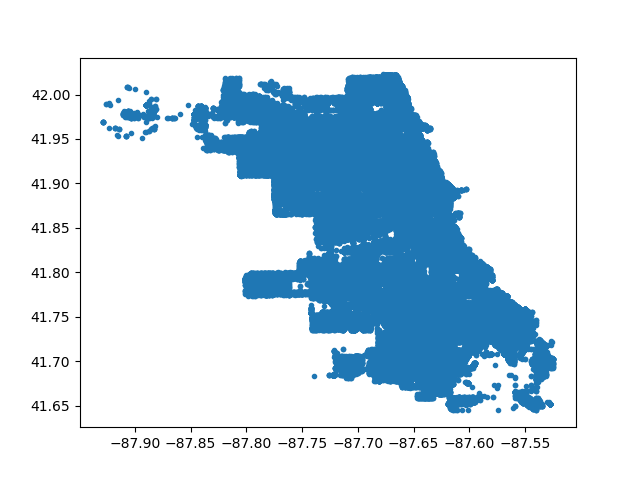

In [6]:
fig, ax = plt.subplots()
ax.plot(crime["LONGITUDE"], crime["LATITUDE"], '.')

In [74]:
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row.loc[lon],row.loc[lat]]
        for prop in properties:
            feature['properties'][prop] = row.loc[prop]
        geojson['features'].append(feature)
    return geojson

In [52]:
geojson = df_to_geojson(crime,
                        ['BLOCK',' PRIMARY DESCRIPTION',' SECONDARY DESCRIPTION',' LOCATION DESCRIPTION'],
                        lat='LATITUDE', lon='LONGITUDE')

In [53]:
geojson_str = json.dumps(geojson, separators=(',', ':'))

In [54]:
output_filename = 'crimes_map.geojson'
with open(output_filename, 'w') as output_file:
    output_file.write(f"var crimes = {geojson_str};")

In [55]:
print(np.mean(crime["LATITUDE"]))
print(np.mean(crime["LONGITUDE"]))

41.84363810292364
-87.6716738084673


In [56]:
np.any(np.isnan(crime.LATITUDE))

False

In [57]:
np.any(np.isnan(crime.LONGITUDE))

False

In [7]:
crime_count = crime[["LATITUDE","LONGITUDE","BLOCK"]].groupby(["LATITUDE","LONGITUDE"]).count()
crime_count.reset_index(inplace=True)
crime_count.columns = ["lat","lon","count"]
crime_count.head()

,lat,lon,count
0,41.644604,-87.610728,2
1,41.644606,-87.606301,1
2,41.644608,-87.613055,1
3,41.644612,-87.601570,1
4,41.644818,-87.614692,1


In [8]:
crime_count["count"].max()

482

In [9]:
crime_count_json = json.dumps(list(crime_count.T.to_dict().values()))

In [10]:
output_filename = 'crimes_count.json'
with open(output_filename, 'w') as output_file:
    output_file.write(f"{crime_count_json};")

In [110]:
geojson_count = df_to_geojson(crime_count, ['count'], lat='lat', lon='lon')
geojson_count_str = json.dumps(geojson_count, separators=(',', ':'))

In [111]:
output_filename = 'crimes_count.geojson'
with open(output_filename, 'w') as output_file:
    output_file.write(f"var crimes = {geojson_count_str};")

In [176]:
latmin, latmax = crime_count["lat"].min(), crime_count["lat"].max()
lonmin, lonmax = crime_count["lon"].min(), crime_count["lon"].max()
path = np.array([np.linspace(latmax, latmin, 100), np.linspace(lonmin, lonmax, 100)]).T

In [177]:
lonmin,lonmax

(-87.928909442, -87.524529378)

In [178]:
latmin,latmax

(41.644604096, 42.022671246)

In [124]:
path_json = json.dumps(path.tolist())

output_filename = 'path.json'
with open(output_filename, 'w') as output_file:
    output_file.write(f"var path = {path_json};")

<IPython.core.display.Javascript object>


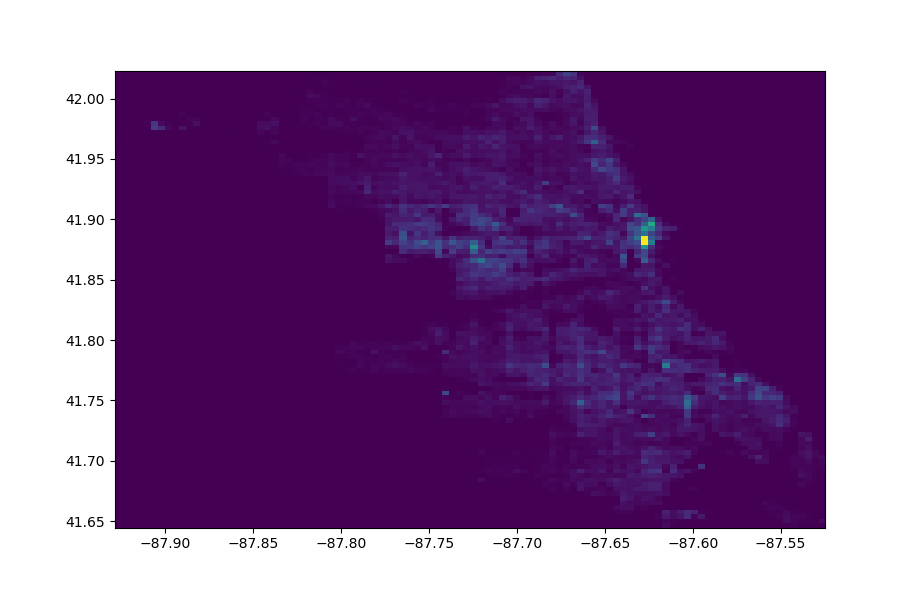

In [26]:
fig, ax = plt.subplots()
ax.hist2d(crime_count.lon, crime_count.lat, bins=100, weights=crime_count["count"]);

In [166]:
bins = 100
nbags = 1000
thresh = 200
crime_hist, xedges, yedges = np.histogram2d(crime_count.lon, crime_count.lat, bins=bins, weights=crime_count["count"])
crime_hist = np.flip(crime_hist.T, 0)
moneybags = np.random.randint(0,100,[nbags,2])
moneybags = np.array([[x,y] for x,y in moneybags if crime_hist[x,y] > thresh]).T

In [185]:
def random_latlon(k=20):
    n = crime.shape[0]
    a = np.random.choice(range(n), size=k, replace=False)
    return crime[["LATITUDE","LONGITUDE"]].iloc[a]

In [189]:
random_latlon(5)

,LATITUDE,LONGITUDE
60399,41.971061,-87.708548
22321,42.015517,-87.679075
146212,41.890992,-87.703955
34715,41.963447,-87.739909
133531,41.878344,-87.709510


In [196]:
json.dumps(random_latlon(100).values.tolist())

'[[41.761546495, -87.58182888], [41.74646296, -87.741266075], [41.955040757, -87.673811504], [41.707517481, -87.601963561], [41.944990051, -87.654734714], [41.693422806, -87.62923627200001], [41.9105227, -87.74745280799999], [41.894781156, -87.634962524], [41.778578136, -87.7293926], [41.803424622, -87.58187886299999], [41.88249622, -87.624380767], [41.861790204, -87.729931778], [41.889535164, -87.749150406], [41.767941308000005, -87.63228200100001], [41.793895354, -87.61736360200001], [41.882213693000004, -87.654374823], [41.867251542, -87.639594427], [41.779798546, -87.64164873899999], [41.931047438, -87.78250845299999], [41.685591052, -87.53526325700001], [41.657907413000004, -87.60012455100001], [41.879393185, -87.632992969], [41.793493117, -87.772092239], [41.874804196999996, -87.758427339], [41.806123825, -87.71722440399999], [41.830894909, -87.676826665], [41.727707947, -87.551205466], [41.730233425, -87.665729953], [41.858626059, -87.672108702], [41.851949553000004, -87.6189959

<IPython.core.display.Javascript object>


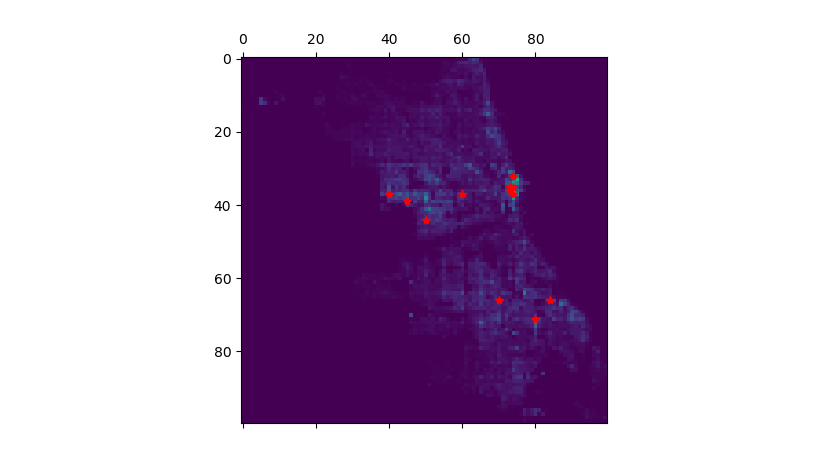

In [152]:
fig, ax = plt.subplots()
ax.matshow(crime_hist)
ax.plot(moneybags[1], moneybags[0], '*', color="red")